## Lab 01(op)
About `he`初始化的联系与`w`的对称性
- 默认的初始化方法旨在让模型在开始训练时具有合理的初始权重，避免出现梯度消失或梯度爆炸的问题。
- 使用 He 初始化，通常是为了在使用 ReLU 激活函数时进一步改善训练效果。

### 导入

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

### 随机化数据(非线性)

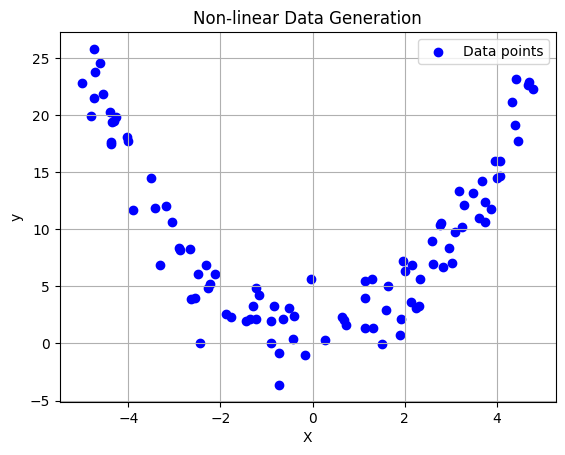

In [2]:
def generate_nonlinear_data(num_samples=100):
    X = np.random.uniform(-5, 5, (num_samples, 1))
    y = X**2 + np.random.normal(0, 2, X.shape)  # 加入一些噪声
    return X, y

# 创建数据
X, y = generate_nonlinear_data(100)

# 可视化数据
plt.scatter(X, y, color='blue', label='Data points')
plt.title('Non-linear Data Generation')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

### 定义模型

In [3]:
class ComplexNet(nn.Module):
    def __init__(self, init_type='he'):
        super(ComplexNet, self).__init__()
        self.fc1 = nn.Linear(1, 64)  # 输入维度应为1
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

        # 初始化权重
        if init_type == 'he':
            nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        elif init_type == 'default':
            pass  # 使用PyTorch的默认初始化
        elif init_type == 'zero':
            nn.init.constant_(self.fc1.weight, 0)  # 将权重初始化为0
            nn.init.constant_(self.fc2.weight, 0)
            nn.init.constant_(self.fc3.weight, 0)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 设置训练函数

In [4]:
# 转换为张量并创建数据加载器
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 设置超参数
num_epochs = 100
learning_rate = 0.01
# 定义训练函数
def train_model(init_type):
    model = ComplexNet(init_type=init_type)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    losses = []
    weight_distributions = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        average_loss = epoch_loss / len(dataloader)
        losses.append(average_loss)
        weights = model.fc1.weight.data.cpu().numpy().flatten()  # 选择第一层的权重
        weight_distributions.append(weights)
        
    return losses, weight_distributions

In [5]:
# 训练使用 He 初始化的模型
losses_he, weight_he = train_model(init_type='he')
print(f'Loss with He initialization: {losses_he[-1]:.4f}')

# 训练不使用 He 初始化的模型
losses_default, weight_def = train_model(init_type='default')
print(f'Loss without He initialization: {losses_default[-1]:.4f}')

# 训练使用零初始化的模型
losses_zero, weight_zero = train_model(init_type='zero')
print(f'Loss with zero initialization: {losses_zero[-1]:.4f}')

Loss with He initialization: 3.7998
Loss without He initialization: 4.0762
Loss with zero initialization: 5.1968


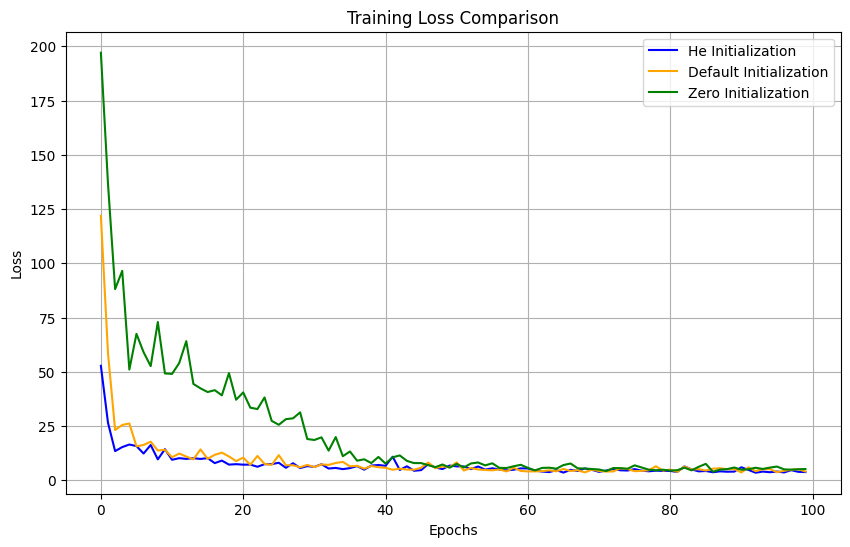

In [6]:
# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(losses_he, label='He Initialization', color='blue')
plt.plot(losses_default, label='Default Initialization', color='orange')
plt.plot(losses_zero, label='Zero Initialization', color='green')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

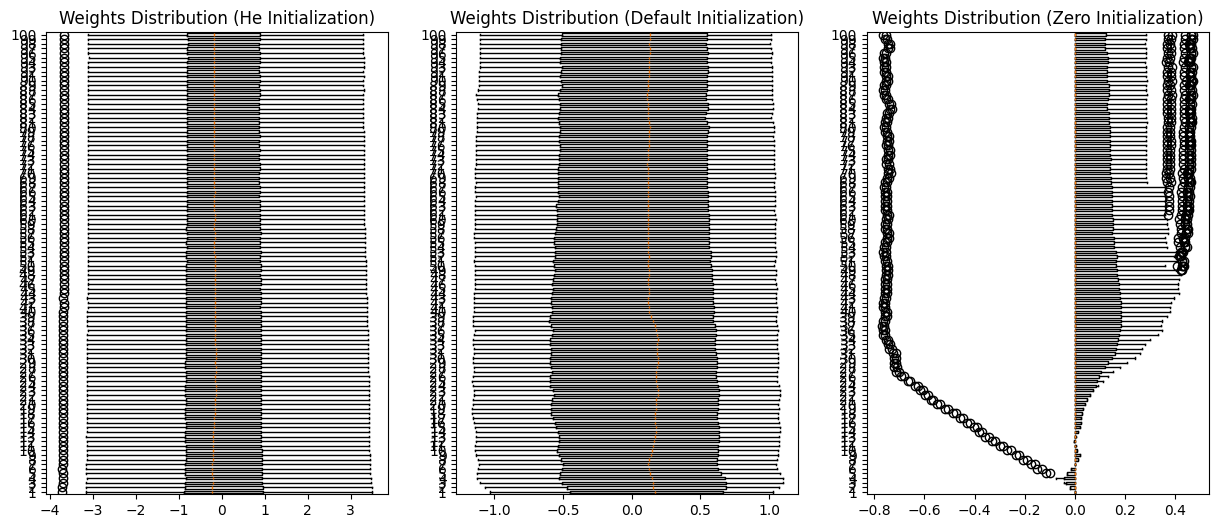

In [7]:
# 可视化权重分布
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.title('Weights Distribution (He Initialization)')
plt.boxplot(weight_he, vert=False)
plt.subplot(1, 3, 2)
plt.title('Weights Distribution (Default Initialization)')
plt.boxplot(weight_def, vert=False)
plt.subplot(1, 3, 3)
plt.title('Weights Distribution (Zero Initialization)')
plt.boxplot(weight_zero, vert=False)
plt.show()


- He初始化：通过从正态分布中随机采样，提供了不同的随机权重，有助于打破对称性，从而使每个神经元在训练中能学习到不同的特征。
权重初始化为0：所有神经元的权重相同，导致它们在前向传播和反向传播时对输入的响应完全相同，从而无法有效学习不同的特征，容易导致模型无法收敛。
- He初始化：促进了有效的梯度传递，尤其是在深层网络中，有助于防止梯度消失或梯度爆炸。
权重初始化为0：会导致在训练过程中产生不适当的梯度，最终使得权重无法更新，模型无法学习。
- He初始化：通常能够加速收敛，提高模型的最终性能。
权重初始化为0：通常导致模型性能极差，尤其是在复杂任务中，无法正确拟合数据。